# ECG Uncertainty Quantification with random electrodes

In this notebook we consider the problem of estimating expectation and variance of the standard ECG when the position of the electrodes on the chest is a random variable.

Here we consider the simplified setting of a 2D domain.

In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from lrchol import *
from utils import *
import seaborn as sns
from tqdm import tqdm,trange

sns.set()
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

## Mesh creation

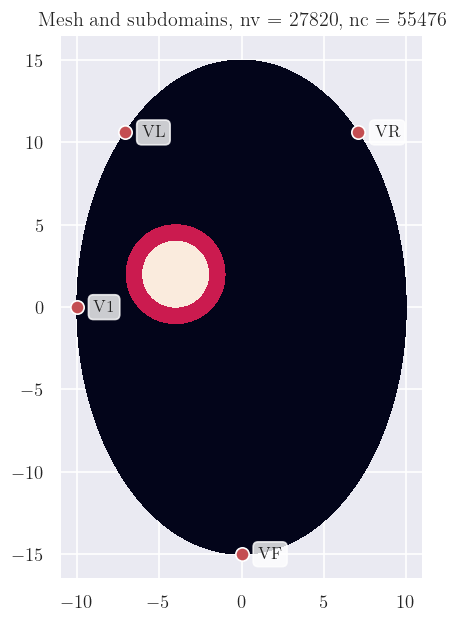

In [2]:
# size of heart and torso [cm]
Hx = -4.0; Hy =  2.0;
R1 =  3.0; R2 =  2.0;
Tx = 10.0; Ty = 15.0;

# import the mesh from gmsh
mm,markers = import_from_gmsh("SimpleTorso2D.msh")
TORSO,HEART,BLOOD = markers[2]['torso'],markers[2]['heart'],markers[2]['blood']
cfun = MeshFunction('size_t',mm,2,mm.domains())

# electrodes are marked in the mesh, we retrieve the index
elec = {el.replace('elec',''): next(idx for idx,v in mm.domains().markers(0).items() if v == tag)
        for el,tag in markers[0].items() if el.startswith('elec')}

plt.figure(dpi=120,figsize=(4,6))
plot(cfun)
for el,idx in elec.items():
    ex = mm.coordinates()[idx,:]
    plt.plot(*ex,'ro',markersize=8,markeredgecolor='w')
    plt.annotate(el,ex,weight='bold',size='small',
             textcoords="offset points",xytext=(10,0),va='center',
             bbox={'facecolor':'w','alpha': 0.8,'boxstyle':'round'})

plt.grid()
plt.title(f'Mesh and subdomains, nv = {mm.num_vertices()}, nc = {mm.num_cells()}');

## Probability densities for electrodes

### Parametrization of the chest

In [3]:
mb  = BoundaryMesh(mm,"exterior",True)
P1e = FiniteElement("CG",mb.ufl_cell(),1)
Ve  = FunctionSpace(mb,P1e)
bmap = mb.entity_map(0).array()

sfun = Function(Ve,name="sfun")

s0 = next(idx for idx,v in mm.domains().markers(0).items() if v == markers[0]['s0'])
curvilinear_coordinate_1d(mb,p0=bmap.tolist().index(s0),function=sfun)

### Densities

Electrode unif_VF: mass = 1.00000, mean = 19.83028, std = 1.01181
Electrode gaus_VF: mass = 1.00000, mean = 19.83028, std = 0.88935
Electrode unif_VR: mass = 1.00000, mean = 68.16967, std = 0.98690
Electrode gaus_VR: mass = 1.00000, mean = 68.16425, std = 0.88823
Electrode unif_VL: mass = 1.00000, mean = 50.81215, std = 0.98690
Electrode gaus_VL: mass = 1.00000, mean = 50.81757, std = 0.88823
Electrode unif_V1: mass = 1.00000, mean = 39.64173, std = 1.00112
Electrode gaus_V1: mass = 1.00000, mean = 39.65970, std = 0.88887


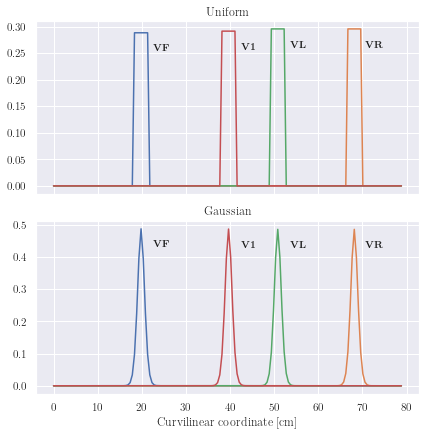

In [4]:
# radius of uniform distribution
unif_delta = 1.5
# std of gaussian distribution
gaus_sigma = sqrt(1/3)*unif_delta

# attach distributions to electrodes
elec_rhos = {}
for ename,idx in elec.items():
    rho_unif = Function(Ve,name=f"rho_unif_{ename}")
    rho_gaus = Function(Ve,name=f"rho_gaus_{ename}")
    # center of distribution
    pidx = bmap.tolist().index(idx)
    p0 = Point(mb.coordinates()[pidx,:])
    # build distribution
    uniform_distribution(mb,pidx,unif_delta,function=rho_unif)
    gaussian_distribution(mb,p0,gaus_sigma,function=rho_gaus)
    # assign
    elec_rhos[f'unif_{ename}'] = rho_unif
    elec_rhos[f'gaus_{ename}'] = rho_gaus

# visualization (use curvilinear coordinate)
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6))
ss = sfun.vector().get_local()
ii = np.argsort(ss)

for ename,rho in elec_rhos.items():
    
    mass = assemble(rho*dx)
    rho_mean = assemble(sfun*rho*dx)
    rho_std  = np.sqrt(assemble(sfun**2*rho*dx) - rho_mean**2)
    ss_vec   = ss[ii]
    rho_vec  = rho.vector()[ii]
    print(f"Electrode {ename}: mass = {mass:.5f}, mean = {rho_mean:.5f}, std = {rho_std:.5f}")

    if ename.startswith('unif'):
        lbl = ename.replace('unif_','')
        ax = ax1
    else:
        lbl = ename.replace('gaus_','')
        ax = ax2
        
    ax.plot(ss_vec,rho_vec)
    ax.annotate(f'\\textbf{{{lbl}}}',(rho_mean,0.9*rho_vec.max()),size='small',
                 textcoords="offset points",xytext=(20,0),va='center',ha='center')

ax1.set_title('Uniform')
ax2.set_title('Gaussian')
plt.tight_layout()
ax2.set_xlabel('Curvilinear coordinate [cm]')
fig.savefig('rho_dist.pdf')

## Forward bidomain solution

### Model parameters

In [5]:
# Heart mesh
mh = SubMesh(mm,cfun,HEART)
P1 = FiniteElement("P",mh.ufl_cell(),1)
Vh = FunctionSpace(mh,P1)
# map from mh index to mm index
vmap = mh.data().array('parent_vertex_indices', 0)

# EP
beta = Constant(800.0,name="beta")
Cm   = Constant(1.0,name="Cm")

# fibers, parametrized with mesh
def fib(mesh):
    vr = SpatialCoordinate(mesh) - Constant((Hx,Hy))
    vn = sqrt(dot(vr,vr))
    ff = as_vector([vr[1]/vn,-vr[0]/vn])
    return ff

# conductivities
sigma_il = Constant(3.0,name="sigma_il")
sigma_it = Constant(0.3,name="sigma_it")
sigma_el = Constant(3.0,name="sigma_el")
sigma_et = Constant(1.2,name="sigma_et")
sigma_t  = Constant(2.0,name="sigma_t")
sigma_b  = Constant(6.0,name="sigma_b")
sigma_ml = sigma_el*sigma_il/(sigma_el+sigma_il)
sigma_mt = sigma_et*sigma_it/(sigma_et+sigma_it)

d   = mm.topology().dim()
Gi  = lambda m: sigma_it*Identity(d) + (sigma_il-sigma_it)*outer(fib(m),fib(m))
Ge  = lambda m: sigma_et*Identity(d) + (sigma_el-sigma_et)*outer(fib(m),fib(m))
Gm  = lambda m: sigma_mt*Identity(d) + (sigma_ml-sigma_mt)*outer(fib(m),fib(m))

# stimulus
X = SpatialCoordinate(mh)
tim  = Constant(0.0,name="time")
tons = Constant(1.0,name="stim_onset")
tdur = Constant(2.0,name="stim_dur")
smax = Constant(100.0,name="stim_max")
srad = Constant(0.1,name="stim_radius")
sx = Constant((Hx+R2,Hy),name="stim_pos")
Istim = conditional(abs(tim-tons-tdur/2.0)<=tdur/2.0, conditional(sqrt(dot(X-sx,X-sx))<=srad,smax,0),0)

# ionic model (Nagumo, no repolarization)
Vrest = -85.0
Vdep  = +30.0
Vthre = -55.0
Rmax  = 1.4e-3
fion = lambda Vm: Rmax*(Vm-Vdep)*(Vm-Vrest)*(Vm-Vthre)

# temporal discretization
dt   = Constant(0.02,name="dt")
Tmax = 130.0
ndt  = int(np.rint(Tmax/float(dt)))+1
ndtE = 50

### Leads set

In [7]:
leads = {'unif_II': [(+1.0,  elec_rhos['unif_VF']), (-1.0,  elec_rhos['unif_VL'])],
         'gaus_II': [(+1.0,  elec_rhos['gaus_VF']), (-1.0,  elec_rhos['gaus_VL'])],
         'unif_V1': [(+1.0,  elec_rhos['unif_V1']), (-1/3., elec_rhos['unif_VF']),
                     (-1/3., elec_rhos['unif_VL']), (-1/3., elec_rhos['unif_VR'])],
         'gaus_V1': [(+1.0,  elec_rhos['gaus_V1']), (-1/3., elec_rhos['gaus_VF']),
                     (-1/3., elec_rhos['gaus_VL']), (-1/3., elec_rhos['gaus_VR'])] }


### Eikonal problem (via heat method)

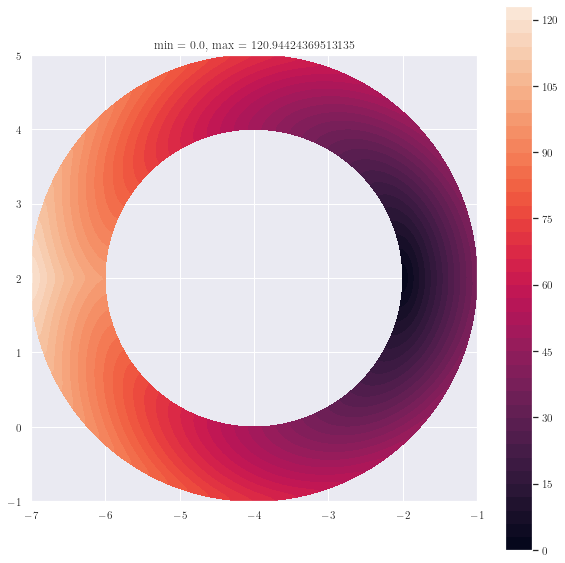

In [18]:
# the activation map
tau = Function(Vh,name="tau")

# conduction velocity
CVl = 65.0 * 1e-3  # cm/ms
alpha = Constant(CVl**2/float(sigma_ml),name="alpha")
DD = alpha*Gm(mh)

# pacing site
from scipy.spatial import cKDTree as kdtree
_,idx = kdtree(mh.coordinates()).query([Hx+R2,Hy])
x0 = mh.coordinates()[idx,:]

# first step of heat method, solution of heat equation
tt = Constant(4.0,name="dteiko")
u,v = TrialFunction(Vh),TestFunction(Vh)
A = assemble(u*v*dx + tt * inner(DD*grad(u),grad(v))*dx)
L = Constant(0.0)*v*dx

b = assemble(L)
ps = PointSource(Vh,Point(x0),1.0)
ps.apply(b)

solve(A,tau.vector(),b)

# second step, recover activation from gradient
# (singular Neumann)
K = assemble(inner(DD*grad(u),grad(v))*dx)
b = assemble(-inner(DD*grad(tau)/sqrt(dot(DD*grad(tau),grad(tau))),grad(v))*dx)

solverE = PETScKrylovSolver("cg")
solverE.set_operator(K)
v0 = Vector(tau.vector())
Vh.dofmap().set(v0, 1.0)
v0 *= 1.0/v0.norm("l2")
null_space = VectorSpaceBasis([v0])
as_backend_type(K).set_nullspace(null_space)

null_space.orthogonalize(b)
solverE.solve(tau.vector(),b)

# set initial condition to zero
tau.vector()[:] -= tau.vector()[vertex_to_dof_map(Vh)[idx]]

fig = plt.figure(figsize=(10,10))
a = plot(tau)
plt.colorbar(a)
plt.title(f'min = {tau.vector().min()}, max = {tau.vector().max()}')

with XDMFFile(f"tau.xdmf") as f:
    f.write(tau)

In [8]:
# store solution for later use
eps = 0.4
tau_val = tau.vector().get_local()

VVm = np.zeros((ndt//ndtE+1,Vh.dim()))
for k in trange(1,VVm.shape[0]):
    t = ndtE*k*float(dt)
    VVm[k,:] = float(Vrest)+(float(Vdep)-float(Vrest))/2*(1+np.tanh((t-tau_val-float(tons))/eps))

100%|██████████| 130/130 [00:00<00:00, 5183.47it/s]


### Torso problem

In [9]:
V = FunctionSpace(mm,P1)
VmT = Function(V,name="Vm_torso")
ue  = Function(V,name="ue")

u,v = TrialFunction(V),TestFunction(V)
dxx  = Measure("dx",domain=mm,subdomain_data=cfun)
Atorso = inner((Gi(mm)+Ge(mm))*grad(u),grad(v))*dxx(HEART) \
       + sigma_b*inner(grad(u),grad(v))*dxx(BLOOD) \
       + sigma_t*inner(grad(u),grad(v))*dxx(TORSO)
Ltorso = -inner(Gi(mm)*grad(VmT),grad(v))*dxx(HEART)

At = assemble(Atorso)
bt = assemble(Ltorso)
solverT = PETScKrylovSolver("cg")
solverT.set_operator(At)

# nullspace for torso problem
v0 = Vector(VmT.vector())
V.dofmap().set(v0, 1.0)
v0 *= 1.0/v0.norm("l2")
null_space = VectorSpaceBasis([v0])
as_backend_type(At).set_nullspace(null_space)

# solution
#
VECG = {lname: np.zeros((ndt//ndtE+1,3)) for lname in leads.keys()}
ueb  = Function(Ve,name="ue_bc")

with trange(ndt//ndtE+1) as tbar, XDMFFile("monosol2dv2.xdmf") as fo:
    fo.parameters['functions_share_mesh'] = True
    fo.parameters['rewrite_function_mesh'] = False

    for k in tbar:
        t = ndtE*k*float(dt)

        # assign Vm
        VmT.vector()[vertex_to_dof_map(V)[vmap]] = VVm[k,vertex_to_dof_map(Vh)].copy()
        
        # solve torso problem
        assemble(Ltorso,tensor=bt)
        null_space.orthogonalize(bt)
        solverT.solve(ue.vector(),bt)
            
        fo.write(ue,t)
        fo.write(VmT,t)

        # compute ECG
        ueb.vector()[vertex_to_dof_map(Ve)] = ue.vector()[vertex_to_dof_map(V)[bmap]]

        for lname,lead in leads.items():
            ex = mm.coordinates()[elec[rho.name().split('_')[2]],:]

            VECG[lname][k,0] = sum(a*ueb(mm.coordinates()[elec[rho.name().split('_')[2]],:])
                                   for a,rho in lead)
            VECG[lname][k,1] = assemble(ueb*sum(a*rho for a,rho in lead)*dx)
            VECG[lname][k,2] = assemble(ueb**2*sum(a**2*rho for a,rho in lead)*dx) \
                             + sum(assemble(a1*ueb*rho1*dx)*assemble(a2*ueb*rho2*dx)
                                   for a1,rho1 in lead
                                   for a2,rho2 in lead
                                   if rho1.name() != rho2.name())

100%|██████████| 131/131 [00:23<00:00,  5.65it/s]


## Leadfield approach

### Point-wise evaluation

In [10]:
# Problem for point-wise evaluation of ECG
#

VECGZ = {}
Zout = XDMFFile("Zpts.xdmf")
Zout.parameters['functions_share_mesh'] = True

for lname,lead in leads.items():
    
    # assemble rhs with delta
    Lpt = Constant(0.0)*TestFunction(V)*ds
    assemble(Lpt,tensor=bt)
    for a,rho in lead:
        ename = rho.name().split('_')[2]
        ex = mm.coordinates()[elec[ename],:]
        PointSource(V,Point(ex),-a).apply(bt)
    null_space.orthogonalize(bt)
    
    # solve
    u = Function(V,name=f"Zpts_{lname}")
    solverT.solve(u.vector(),bt)

    # restrict to heart
    Zpt = Function(Vh)
    Vm  = Function(Vh,name="Vm")
    Zpt.vector()[vertex_to_dof_map(Vh)] = u.vector()[vertex_to_dof_map(V)[vmap]]

    # assemble ECG computation
    AH = assemble(dot(Gi(mh)*grad(TestFunction(Vh)),grad(Zpt))*dx)

    # compute ECG
    VECGZ[lname] = np.zeros((ndt//ndtE+1,3))
    for k in trange(VECGZ[lname].shape[0],desc=f'Lead {lname}'):
        Vm.vector().set_local(VVm[k,:])
        VECGZ[lname][k,0] = AH.inner(Vm.vector())

    # store
    Zout.write(u,0.0)
    
Zout.close()

Lead gaus_V1: 100%|██████████| 131/131 [00:00<00:00, 1608.25it/s]


### Average ECG

In [11]:
# Problem for mean ECG
#

Zout = XDMFFile("Zavg.xdmf")
Zout.parameters['functions_share_mesh'] = True

for lname,lead in leads.items():
    
    # assemble rhs
    Lavg = 0
    for a,rho in lead:
        rhoT = Function(V,name=rho.name())
        rhoT.vector()[vertex_to_dof_map(V)[bmap]] = rho.vector()[vertex_to_dof_map(Ve)].copy()
        Lavg += -a*rhoT*TestFunction(V)*ds

    assemble(Lavg,tensor=bt)
    null_space.orthogonalize(bt)
    
    # solve
    u = Function(V,name=f"Zavg_{lname}")
    solverT.solve(u.vector(),bt)

    # restrict to heart
    Zpt = Function(Vh)
    Vm  = Function(Vh,name="Vm")
    Zpt.vector()[vertex_to_dof_map(Vh)] = u.vector()[vertex_to_dof_map(V)[vmap]]

    # assemble ECG computation
    AH = assemble(dot(Gi(mh)*grad(TestFunction(Vh)),grad(Zpt))*dx)

    # compute ECG
    ECG = VECGZ[lname]
    for k in trange(VECGZ[lname].shape[0],desc=f'Lead {lname}'):
        Vm.vector().set_local(VVm[k,:])
        ECG[k,1] = AH.inner(Vm.vector())

    # store
    Zout.write(u,0.0)
    
Zout.close()

Lead gaus_V1: 100%|██████████| 131/131 [00:00<00:00, 1646.17it/s]


### Correlation via low-rank approximation

In [25]:
for lname,lead in leads.items():
    
    # assemble rhs
    uu,vv = TrialFunction(Ve),TestFunction(Ve)
    rrs = [assemble(a*rho*vv*dx).get_local() for a,rho in lead]
    KK1 = assemble(sum(a**2*rho for a,rho in lead)*uu*vv*dx).array()
    KK2 = sum( np.outer(rrs[i],rrs[j]) for i in range(len(rrs)) for j in range(len(rrs)) if i!=j )
    KK = KK1 + KK2

    # low-rank Cholesky factorization
    LL,m = lowRankCholesky(np.diag(KK),lambda i: KK[i,:],tol=1e-4)
    #print(m, np.trace(KK - LL @ LL.T))

    # semi-correlation matrix for ECG
    CorE = np.zeros((VECGZ[lname].shape[0],LL.shape[1]))

    # compute one lead function per mode in LL
    for kk in trange(LL.shape[1],desc=f'Lead {lname}'):
        # assign rhs
        bt.zero()
        bt[vertex_to_dof_map(V)[bmap]] = LL[vertex_to_dof_map(Ve),kk].copy()
        bt.apply("add")
        null_space.orthogonalize(bt)
        
        # solve
        u = Function(V)
        solverT.solve(u.vector(),bt)

        # restrict to heart
        Zpt = Function(Vh)
        Vm  = Function(Vh,name="Vm")
        Zpt.vector()[vertex_to_dof_map(Vh)] = u.vector()[vertex_to_dof_map(V)[vmap]]

        # assemble ECG computation
        AH = assemble(dot(Gi(mh)*grad(TestFunction(Vh)),grad(Zpt))*dx)

        # compute contribution to ECG of this mode
        for k in range(ECG.shape[0]):
            Vm.vector().set_local(VVm[k,:])
            CorE[k,kk] = AH.inner(Vm.vector())

    CorZ = CorE @ CorE.T
    #ECG[:,2] = np.sqrt(np.maximum(np.diag(CorZ) - ECG[:,1]**2,0))
    VECGZ[lname][:,2] = np.diag(CorZ)
    

Lead gaus_V1: 100%|██████████| 59/59 [00:12<00:00,  4.87it/s]


unif_II 0.10648862638751289 0.8382606983290221
Pts l2 error = 0.008616352042480957
Avg l2 error = 0.008237129005801147
Std l2 error = 0.0016062672310046336
gaus_II 0.08392863772561943 0.7588837321054824
Pts l2 error = 0.008616352042480957
Avg l2 error = 0.00825590554668404
Std l2 error = 0.002113094530540871
unif_V1 0.2802369027592668 2.067899585723369
Pts l2 error = 0.004758137110100202
Avg l2 error = 0.003894569942202608
Std l2 error = 0.007288986438650252
gaus_V1 0.20069586126415473 1.7869154820895465
Pts l2 error = 0.004758137110100202
Avg l2 error = 0.00402160385450312
Std l2 error = 0.008511449318931358


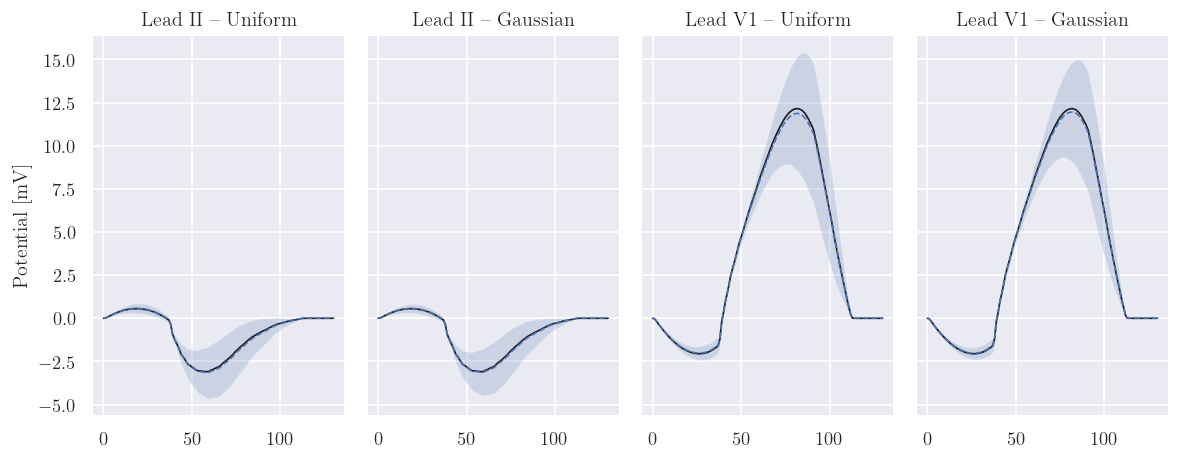

In [28]:
fig,axs = plt.subplots(1,4,sharey=True,dpi=120,figsize=(10,4) )

order = ['unif_II', 'gaus_II', 'unif_V1', 'gaus_V1']
ttt = 1.0*np.arange(ndt//ndtE+1)
for k,lbl in enumerate(order):
    ECG    = VECGZ[lbl]
    ECGref = VECG[lbl]
    
    std    = np.sqrt(np.maximum(ECG[:,2]-ECG[:,1]**2,0))
    stdref = np.sqrt(np.maximum(ECGref[:,2]-ECGref[:,1]**2,0))
    
    axs[k].plot(ttt,ECG[:,0],'k',linewidth=1.0)
    axs[k].plot(ttt,ECG[:,1],'--',linewidth=1.0)
    axs[k].fill_between(ttt,ECG[:,1] - 1.96*std,
                            ECG[:,1] + 1.96*std, alpha=0.2)

    print( lbl, np.abs(ECG[:,0]-ECG[:,1]).max(), std.max() )
    print(f"Pts l2 error = {np.linalg.norm(ECG[:,0]-ECGref[:,0],np.inf)}")
    print(f"Avg l2 error = {np.linalg.norm(ECG[:,1]-ECGref[:,1],np.inf)}")
    print(f"Std l2 error = {np.linalg.norm(std - stdref,np.inf)}")
    
axs[0].set_title('Lead II -- Uniform')
axs[1].set_title('Lead II -- Gaussian')
axs[2].set_title('Lead V1 -- Uniform')
axs[3].set_title('Lead V1 -- Gaussian')

axs[0].set_ylabel('Potential [mV]')
fig.tight_layout();
fig.savefig('ECGcomp.pdf')